In [3]:
! export JAX_PLATFORMS=cpu

/gpfs/cfel/group/cmi/common/psi4/psi4conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


# Hyperfine solutions for H2S

Compute the hyperfine energies and wavefunctions for selected rotational cluster states of $\text{H}_2\text{S}$.
The hyperfine effect is represented by the spin-rotation interaction.

In [4]:
import itertools

import h5py
import hdfdict
import matplotlib.pyplot as plt
import numpy as np
from jax import config
from py3nj import wigner3j
from rovib.hyperfine_xy2 import dipole_xy2, spin_me_xy2, spinrot_xy2
from rovib.symtop import symtop_on_grid_split_angles
from scipy import constants, stats
from scipy.interpolate import RegularGridInterpolator
from scipy.sparse import csr_matrix
from scipy.spatial.transform import Rotation

config.update("jax_enable_x64", True)

KHZ_TO_INVCM = 1.0 / constants.value("speed of light in vacuum") * 10

DEBYE_TO_AU = (
    1e-21
    / constants.value("speed of light in vacuum")
    / constants.value("elementary charge")
    / constants.value("Bohr radius")
)

DEBYE_X_VM_TO_INVCM = (
    constants.value("atomic unit of electric dipole mom.")
    / (constants.value("Planck constant") * constants.value("speed of light in vacuum"))
    / 1e2
    * DEBYE_TO_AU
)

Start by reading the indices of rotational cluster states for different $J$ quanta, sored in file `h2s_cluster_states.txt`. These states were identified in `h2s_clusters.ipynb` notebook.

In [5]:
print("Rotational cluster states")

cluster_state_id = {}

with open("h2s_cluster_states_id.txt", "r") as fl:
    for line in fl:
        w = line.split()
        j = [int(w[0 + i * 12]) for i in range(4)]
        id = [int(w[1 + i * 12]) for i in range(4)]
        sym = [w[3 + i * 12] for i in range(4)]
        assert all(j[0] == elem for elem in j), f"Not all J quanta are equal: {j}"
        j_ = j[0]

        if j_ >= 50:
            cluster_state_id[j_] = {}
            for sym_, id_ in zip(sym, id):
                try:
                    cluster_state_id[j_][sym_].append(id_)
                except KeyError:
                    cluster_state_id[j_][sym_] = [id_]
            print(f"J = {j_}, cluster-state IDs: {cluster_state_id[j_]}")

Rotational cluster states
J = 50, cluster-state IDs: {'B2': [277], 'A2': [242], 'B1': [242], 'A1': [280]}
J = 51, cluster-state IDs: {'A1': [267], 'B1': [299], 'B2': [270], 'A2': [299]}
J = 52, cluster-state IDs: {'B2': [324], 'A2': [291], 'A1': [327], 'B1': [291]}
J = 53, cluster-state IDs: {'A1': [316], 'B1': [354], 'B2': [318], 'A2': [353]}
J = 54, cluster-state IDs: {'B2': [385], 'A2': [345], 'A1': [387], 'B1': [344]}
J = 55, cluster-state IDs: {'A1': [371], 'B1': [413], 'A2': [412], 'B2': [373]}
J = 56, cluster-state IDs: {'B2': [447], 'A2': [399], 'B1': [399], 'A1': [450]}
J = 57, cluster-state IDs: {'A1': [432], 'B1': [487], 'B2': [434], 'A2': [486]}
J = 58, cluster-state IDs: {'B2': [520], 'B1': [468], 'A1': [523], 'A2': [469]}
J = 59, cluster-state IDs: {'A1': [503], 'B1': [565], 'A2': [563], 'B2': [505]}
J = 60, cluster-state IDs: {'B1': [542], 'A1': [600], 'A2': [544], 'B2': [599]}


Load the rovibrational energies and matrix elements of spin-rotation tensors and electric dipole moment, computed and stored in `h2s_cart_me.ipynb` notebook.

In [6]:
pmax = 20
min_J = 50
max_J = 60

print(f"Read state energies and assignments for J = {min_J}..{max_J}")

with h5py.File(f"h2s_enr_pmax{pmax}.h5", "r") as h5:
    enr = hdfdict.load(h5.require_group("energies"), False)
    qua = hdfdict.load(h5.require_group("quanta"), False)

enr = {
    int(J): {sym: enr_sym for sym, enr_sym in enr_J.items()} for J, enr_J in enr.items()
}

qua = {
    int(J): {
        sym: np.array(
            [[i] + elem[0].decode("utf-8").split(",") for i, elem in enumerate(qua_sym)]
        )
        for sym, qua_sym in qua_J.items()
    }
    for J, qua_J in qua.items()
}

for J in enr.keys():
    for sym in enr[J].keys():
        print(
            f"J = {J}, sym = {sym}, enr.shape = {enr[J][sym].shape}, qua.shape = {qua[J][sym].shape}"
        )

print(f"Read spin-rotation and dipole martix elements for J = {min_J}..{max_J}")

sr1 = {}
sr2 = {}
dipole = {}

for J1 in range(min_J, max_J + 1):
    for J2 in range(min_J, max_J + 1):
        try:
            filename = f"h2s_me_pmax{pmax}_j{J1}_j{J2}.h5"
            with h5py.File(filename, "r") as h5:
                print(
                    f"read (J1, J2) = {(J1, J2)}, |dJ| = {abs(J1-J2)}, from file {filename}"
                )
                sr1_ = hdfdict.load(h5.require_group("spin-rotation-H1"), False)
                sr2_ = hdfdict.load(h5.require_group("spin-rotation-H2"), False)
                try:
                    dip = hdfdict.load(h5.require_group("dipole"), False)
                except ValueError:
                    dip = {}

                sr1[(J1, J2)] = {
                    (sym1, sym2): csr_matrix(
                        (me["data"], me["indices"], me["indptr"]),
                        shape=me["shape"],
                    )
                    .toarray()
                    .reshape(len(enr[J1][sym1]), len(enr[J2][sym2]), -1)
                    for sym1, me_sym1 in sr1_.items()
                    for sym2, me in me_sym1.items()
                }

                sr2[(J1, J2)] = {
                    (sym1, sym2): csr_matrix(
                        (me["data"], me["indices"], me["indptr"]),
                        shape=me["shape"],
                    )
                    .toarray()
                    .reshape(len(enr[J1][sym1]), len(enr[J2][sym2]), -1)
                    for sym1, me_sym1 in sr2_.items()
                    for sym2, me in me_sym1.items()
                }

                dipole[(J1, J2)] = {
                    (sym1, sym2): csr_matrix(
                        (me["data"], me["indices"], me["indptr"]),
                        shape=me["shape"],
                    )
                    .toarray()
                    .reshape(len(enr[J1][sym1]), len(enr[J2][sym2]), -1)
                    for sym1, me_sym1 in dip.items()
                    for sym2, me in me_sym1.items()
                }

        except FileNotFoundError:
            pass

Read state energies and assignments for J = 50..60
J = 50, sym = A1, enr.shape = (1000,), qua.shape = (1000, 10)
J = 50, sym = A2, enr.shape = (1000,), qua.shape = (1000, 10)
J = 50, sym = B1, enr.shape = (1000,), qua.shape = (1000, 10)
J = 50, sym = B2, enr.shape = (1000,), qua.shape = (1000, 10)
J = 51, sym = A1, enr.shape = (1000,), qua.shape = (1000, 10)
J = 51, sym = A2, enr.shape = (1000,), qua.shape = (1000, 10)
J = 51, sym = B1, enr.shape = (1000,), qua.shape = (1000, 10)
J = 51, sym = B2, enr.shape = (1000,), qua.shape = (1000, 10)
J = 52, sym = A1, enr.shape = (1000,), qua.shape = (1000, 10)
J = 52, sym = A2, enr.shape = (1000,), qua.shape = (1000, 10)
J = 52, sym = B1, enr.shape = (1000,), qua.shape = (1000, 10)
J = 52, sym = B2, enr.shape = (1000,), qua.shape = (1000, 10)
J = 53, sym = A1, enr.shape = (1000,), qua.shape = (1000, 10)
J = 53, sym = A2, enr.shape = (1000,), qua.shape = (1000, 10)
J = 53, sym = B1, enr.shape = (1000,), qua.shape = (1000, 10)
J = 53, sym = B2, e

Compute hyperfine energies and wavefunctions, identify hyperfine states that belong to the cluster states.

In [7]:
min_F = 50
max_F = 60

hyper_enr = {}
hyper_vec = {}
hyper_qua = {}
hyper_qua_block = {}

hyper_shift = {}
hyper_id = {}
hyper_rov_sym = {}

print(f"Compute hyperfine states for F = {min_F}..{max_F}")

for F in range(min_F, max_F + 1):

    # comupute hyperfine spin-rotation energies and wavefunctions

    hyper_enr[F], hyper_vec[F], hyper_qua[F], hyper_qua_block[F] = spinrot_xy2(
        F, enr, qua, sr1, sr2, spin_states=((0, "B2"), (1, "A1")), spins=(0.5, 0.5)
    )

    # select hyperfine cluster states based on the largest
    # leading contribution from one of the cluster states

    hyper_id[F] = {}
    for sym in hyper_enr[F].keys():
        ind = np.argmax(hyper_vec[F][sym] ** 2, axis=0)
        id = [
            list(
                np.where(
                    (hyper_qua[F][sym][ind, 4].astype(int) == rov_ind[0])
                    & (hyper_qua[F][sym][ind, 1] == rov_sym)
                    & (hyper_qua[F][sym][ind, 0].astype(int) == int(F))
                )[0]
            )
            for rov_sym, rov_ind in cluster_state_id[int(F)].items()
        ]  # indices of hyperfine states with leading contribution from cluster states
        hyper_id[F][sym] = sum(id, [])

    # print assignments of hypefine cluster states

    hyper_shift[F] = {sym: [] for sym in hyper_id[F].keys()}
    hyper_rov_sym[F] = {sym: [] for sym in hyper_id[F].keys()}
    for sym in hyper_id[F].keys():
        for i in hyper_id[F][sym]:
            ind = np.argmax(hyper_vec[F][sym][:, i] ** 2, axis=0)
            rov_ind = int(hyper_qua[F][sym][ind][4])
            rov_sym = hyper_qua[F][sym][ind][1]
            j = int(hyper_qua[F][sym][ind][0])
            rov_enr = enr[j][rov_sym][rov_ind]
            hyper_shift[F][sym].append((hyper_enr[F][sym][i] - rov_enr) / KHZ_TO_INVCM)
            hyper_rov_sym[F][sym].append(rov_sym)
            print(
                f"F = {F}, sym = {sym}, enr = {hyper_enr[F][sym][i]}, shift (kHz) = {hyper_shift[F][sym][-1]}, "
                + f"leading quanta = {hyper_qua[F][sym][ind]}, max(c**2) = {hyper_vec[F][sym][ind, i]**2}"
            )

Compute hyperfine states for F = 50..60
F = 50, sym = B1, enr = 24708.81878741134, shift (kHz) = -251.31552741805572, leading quanta = ['50' 'A2' '0' 'B2' '242' 'A2' '50' '0' '1' '2' 'A1' '35' '1' 'A2'], max(c**2) = (0.9304308871320092-0j)
F = 50, sym = B1, enr = 24708.818907908753, shift (kHz) = 235.5133736800286, leading quanta = ['50' 'B1' '1' 'A1' '242' 'B1' '50' '0' '1' '2' 'A1' '36' '1' 'B1'], max(c**2) = (0.930430887132007+0j)
F = 50, sym = B2, enr = 24708.818786957, shift (kHz) = -264.91317333625705, leading quanta = ['50' 'B2' '1' 'A1' '277' 'B2' '50' '1' '0' '2' 'B2' '50' '0' 'A1'], max(c**2) = (0.931559792337291-0j)
F = 50, sym = B2, enr = 24708.81890837051, shift (kHz) = 249.11243742842126, leading quanta = ['50' 'A1' '0' 'B2' '280' 'A1' '50' '1' '0' '2' 'B2' '45' '0' 'B2'], max(c**2) = (0.9315597923372968+0j)
F = 51, sym = B1, enr = 25447.364236702033, shift (kHz) = -329.44004317473735, leading quanta = ['51' 'B1' '1' 'A1' '299' 'B1' '51' '2' '0' '0' 'A1' '26' '1' 'B1'], m

Plot absolute values of hyperfine shifts for all cluster states as function of quantum number of total angular momentum $F$.

When examining the square of the coefficient for the leading basis function, it remains close to 0.9 for $J=50..54$.
In this range, the plot shows that the hyperfine shift for different symmetries alternates sign between even and odd $J$ values.
However, for $J\geq 55$, this behavior is not evident in the plots.
This is because the square of the coefficient for the leading function approaches $1/\sqrt{2}$ leading
to an ambiguous assignment of states based on rovibrational symmetry, as several states become strongly coupled.

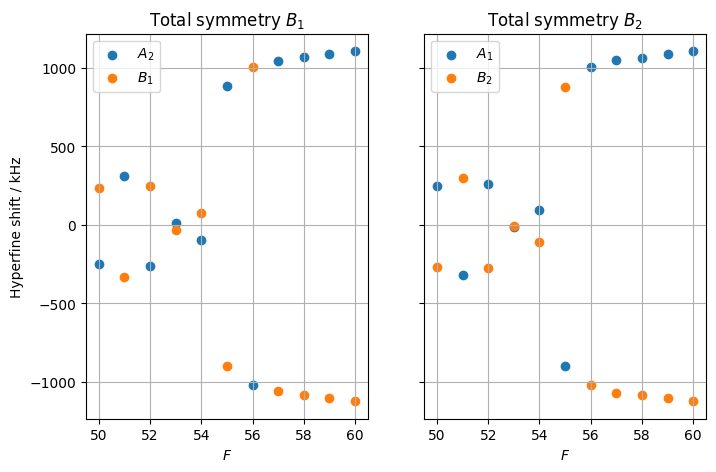

In [8]:
F_list = list(hyper_shift.keys())

shift_B1 = np.array(
    [
        sum([val for sym, val in hyper_shift[F].items() if sym == "B1"], [])
        for F in hyper_shift.keys()
    ]
)

shift_B2 = np.array(
    [
        sum([val for sym, val in hyper_shift[F].items() if sym == "B2"], [])
        for F in hyper_shift.keys()
    ]
)

rov_sym_B1 = np.array(
    [
        sum([val for sym, val in hyper_rov_sym[F].items() if sym in ("A2", "B1")], [])
        for F in hyper_shift.keys()
    ]
)

rov_sym_B2 = np.array(
    [
        sum([val for sym, val in hyper_rov_sym[F].items() if sym in ("A1", "B2")], [])
        for F in hyper_shift.keys()
    ]
)

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 5))

for sym in ("A2", "B1"):
    ind = [np.where(rov_sym_B1[i] == sym)[0] for i in range(len(F_list))]
    sh = [shift_B1[i, j] for i, j in enumerate(ind)]
    ax[0].scatter(F_list, sh, label=f"${sym[0]}_{sym[1]}$")

for sym in ("A1", "B2"):
    ind = [np.where(rov_sym_B2[i] == sym)[0] for i in range(len(F_list))]
    sh = [shift_B2[i, j] for i, j in enumerate(ind)]
    ax[1].scatter(F_list, sh, label=f"${sym[0]}_{sym[1]}$")

ax[0].set_title("Total symmetry $B_1$")
ax[0].set_xlabel("$F$")
ax[0].set_ylabel("Hyperfine shift / kHz")
ax[0].grid()
ax[0].legend()

ax[1].set_title("Total symmetry $B_2$")
ax[1].set_xlabel("$F$")
# ax[1].set_ylabel("Hyperfine shift / kHz")
ax[1].grid()
ax[1].legend()
plt.show()

## Simplified calculation including only cluster states

We also compute hyperfine energies and wavefunctions including only rotational cluster states for selected rotational quantum number $J$ into the basis and neglect the coupling of states with $|\Delta J|>0$.

The results in the printout of hyperfine states and the plot of hyperfine shifts below are numerically identical to those calculated above considering all states.

Load the rovibrational energies and matrix elements of spin-rotation tensors and electric dipole moment, computed and stored in `h2s_cart_me.ipynb` notebook. Select only cluster states.

In [9]:
pmax = 20
min_J = 50
max_J = 60

print(f"Read state energies and assignments for J = {min_J}..{max_J}")

with h5py.File(f"h2s_enr_pmax{pmax}.h5", "r") as h5:
    enr_ = hdfdict.load(h5.require_group("energies"), False)
    qua_ = hdfdict.load(h5.require_group("quanta"), False)

enr_cluster = {
    J: {sym: enr_[str(J)][sym][id] for sym, id in id_J.items()}
    for J, id_J in cluster_state_id.items()
}

qua_cluster = {
    J: {
        sym: np.array(
            [
                [i] + list(elem[0].decode("utf-8").split(","))
                for elem, i in zip(qua_[str(J)][sym][id], id)
            ]
        )
        for sym, id in id_J.items()
    }
    for J, id_J in cluster_state_id.items()
}

for J in enr_cluster.keys():
    for sym in enr_cluster[J].keys():
        print(
            f"J = {J}, sym = {sym}, enr.shape = {enr_cluster[J][sym].shape}, "
            + f"qua.shape = {qua_cluster[J][sym].shape}"
        )

print(f"Read spin-rotation and dipole matrix elements for J = {min_J}..{max_J}")

sr1_cluster = {}
sr2_cluster = {}
dipole_cluster = {}

for J1, id_J1 in cluster_state_id.items():
    for J2, id_J2 in cluster_state_id.items():
        try:
            filename = f"h2s_me_pmax{pmax}_j{J1}_j{J2}.h5"
            with h5py.File(filename, "r") as h5:
                print(
                    f"read (J1, J2) = {(J1, J2)}, |dJ| = {abs(J1-J2)}, from file {filename}"
                )
                sr1 = hdfdict.load(h5.require_group("spin-rotation-H1"), False)
                sr2 = hdfdict.load(h5.require_group("spin-rotation-H2"), False)
                try:
                    dip = hdfdict.load(h5.require_group("dipole"), False)
                except ValueError:
                    dip = {}

                oper_sym = [{}, {}, {}]
                for sym1, id1 in id_J1.items():
                    for sym2, id2 in id_J2.items():
                        nstates1 = len(enr_[str(J1)][sym1])
                        nstates2 = len(enr_[str(J2)][sym2])
                        for i, oper in enumerate((sr1, sr2, dip)):
                            if sym1 in oper and sym2 in oper[sym1]:
                                me = oper[sym1][sym2]
                                oper_sym[i][(sym1, sym2)] = (
                                    csr_matrix(
                                        (me["data"], me["indices"], me["indptr"]),
                                        shape=me["shape"],
                                    )
                                    .toarray()
                                    .reshape(nstates1, nstates2, -1)[np.ix_(id1, id2)]
                                )
                sr1_cluster[(J1, J2)] = oper_sym[0]
                sr2_cluster[(J1, J2)] = oper_sym[1]
                dipole_cluster[(J1, J2)] = oper_sym[2]
        except FileNotFoundError:
            pass

Read state energies and assignments for J = 50..60
J = 50, sym = B2, enr.shape = (1,), qua.shape = (1, 10)
J = 50, sym = A2, enr.shape = (1,), qua.shape = (1, 10)
J = 50, sym = B1, enr.shape = (1,), qua.shape = (1, 10)
J = 50, sym = A1, enr.shape = (1,), qua.shape = (1, 10)
J = 51, sym = A1, enr.shape = (1,), qua.shape = (1, 10)
J = 51, sym = B1, enr.shape = (1,), qua.shape = (1, 10)
J = 51, sym = B2, enr.shape = (1,), qua.shape = (1, 10)
J = 51, sym = A2, enr.shape = (1,), qua.shape = (1, 10)
J = 52, sym = B2, enr.shape = (1,), qua.shape = (1, 10)
J = 52, sym = A2, enr.shape = (1,), qua.shape = (1, 10)
J = 52, sym = A1, enr.shape = (1,), qua.shape = (1, 10)
J = 52, sym = B1, enr.shape = (1,), qua.shape = (1, 10)
J = 53, sym = A1, enr.shape = (1,), qua.shape = (1, 10)
J = 53, sym = B1, enr.shape = (1,), qua.shape = (1, 10)
J = 53, sym = B2, enr.shape = (1,), qua.shape = (1, 10)
J = 53, sym = A2, enr.shape = (1,), qua.shape = (1, 10)
J = 54, sym = B2, enr.shape = (1,), qua.shape = (1, 1

Compute hyperfine energies and wavefunctions

In [11]:
min_F = 50
max_F = 60

hyper_enr_cluster = {}
hyper_vec_cluster = {}
hyper_qua_cluster = {}
hyper_qua_block_cluster = {}

hyper_shift_cluster = {}
hyper_rov_sym_cluster = {}

for F in range(min_F, max_F + 1):

    J = F

    # comupute hyperfine spin-rotation energies and wavefunctions

    (
        hyper_enr_cluster[F],
        hyper_vec_cluster[F],
        hyper_qua_cluster[F],
        hyper_qua_block_cluster[F],
    ) = spinrot_xy2(
        F,
        {J: enr_cluster[J]},
        {J: qua_cluster[J]},
        {(J, J): sr1_cluster[(J, J)]},
        {(J, J): sr2_cluster[(J, J)]},
        spin_states=((0, "B2"), (1, "A1")),
        spins=(0.5, 0.5),
    )

    # print assignments of hypefine cluster states

    hyper_shift_cluster[F] = {sym: [] for sym in hyper_enr_cluster[F].keys()}
    hyper_rov_sym_cluster[F] = {sym: [] for sym in hyper_enr_cluster[F].keys()}
    for sym in hyper_enr_cluster[F].keys():
        for i in range(len(hyper_enr_cluster[F][sym])):
            ind = np.argmax(hyper_vec_cluster[F][sym][:, i] ** 2, axis=0)
            rov_ind = int(hyper_qua_cluster[F][sym][ind][4])
            rov_sym = hyper_qua_cluster[F][sym][ind][1]
            j = int(hyper_qua_cluster[F][sym][ind][0])
            rov_enr = enr_[str(j)][rov_sym][rov_ind]
            hyper_shift_cluster[F][sym].append(
                (hyper_enr_cluster[F][sym][i] - rov_enr) / KHZ_TO_INVCM
            )
            hyper_rov_sym_cluster[F][sym].append(rov_sym)
            print(
                f"F = {F}, sym = {sym}, enr = {hyper_enr_cluster[F][sym][i]}, shift (kHz) = {hyper_shift_cluster[F][sym][-1]}, "
                + f"leading quanta = {hyper_qua_cluster[F][sym][ind]}, max(c**2) = {hyper_vec_cluster[F][sym][ind, i]**2}"
            )

F = 50, sym = B1, enr = 24708.81878741142, shift (kHz) = -251.3131280131165, leading quanta = ['50' 'A2' '0' 'B2' '242' 'A2' '50' '0' '1' '2' 'A1' '35' '1' 'A2'], max(c**2) = (0.930430820742419+0j)
F = 50, sym = B1, enr = 24708.81890790879, shift (kHz) = 235.51446431863732, leading quanta = ['50' 'B1' '1' 'A1' '242' 'B1' '50' '0' '1' '2' 'A1' '36' '1' 'B1'], max(c**2) = (0.930430820742419+0j)
F = 50, sym = B2, enr = 24708.818786957007, shift (kHz) = -264.91295520853527, leading quanta = ['50' 'B2' '1' 'A1' '277' 'B2' '50' '1' '0' '2' 'B2' '50' '0' 'A1'], max(c**2) = (0.9315598651704518-0j)
F = 50, sym = B2, enr = 24708.818908370573, shift (kHz) = 249.1142915140561, leading quanta = ['50' 'A1' '0' 'B2' '280' 'A1' '50' '1' '0' '2' 'B2' '45' '0' 'B2'], max(c**2) = (0.9315598651704518+0j)
F = 51, sym = B1, enr = 25447.364236702117, shift (kHz) = -329.4375347059373, leading quanta = ['51' 'B1' '1' 'A1' '299' 'B1' '51' '2' '0' '0' 'A1' '26' '1' 'B1'], max(c**2) = (0.8995880069142649-0j)
F = 

Plot absolute values of hyperfine shifts for all cluster states as function of quantum number of total angular momentum $F$.

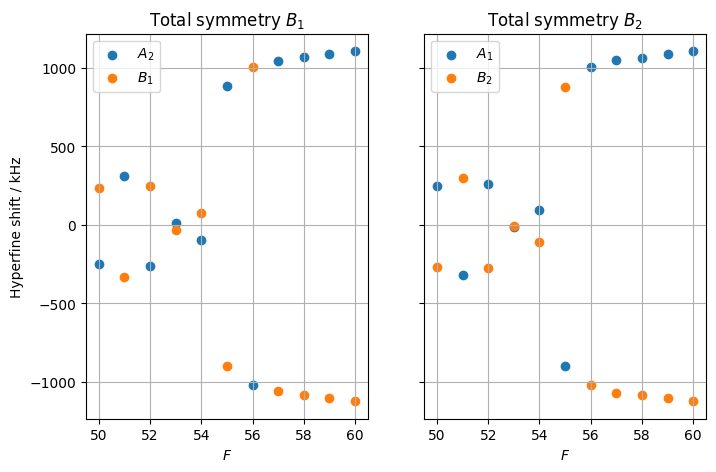

In [12]:
F_list = list(hyper_shift_cluster.keys())

shift_B1 = np.array(
    [
        sum([val for sym, val in hyper_shift_cluster[F].items() if sym == "B1"], [])
        for F in hyper_shift_cluster.keys()
    ]
)

shift_B2 = np.array(
    [
        sum([val for sym, val in hyper_shift_cluster[F].items() if sym == "B2"], [])
        for F in hyper_shift_cluster.keys()
    ]
)

rov_sym_B1 = np.array(
    [
        sum([val for sym, val in hyper_rov_sym_cluster[F].items() if sym in ("A2", "B1")], [])
        for F in hyper_shift_cluster.keys()
    ]
)

rov_sym_B2 = np.array(
    [
        sum([val for sym, val in hyper_rov_sym_cluster[F].items() if sym in ("A1", "B2")], [])
        for F in hyper_shift_cluster.keys()
    ]
)

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 5))

for sym in ("A2", "B1"):
    ind = [np.where(rov_sym_B1[i] == sym)[0] for i in range(len(F_list))]
    sh = [shift_B1[i, j] for i, j in enumerate(ind)]
    ax[0].scatter(F_list, sh, label=f"${sym[0]}_{sym[1]}$")

for sym in ("A1", "B2"):
    ind = [np.where(rov_sym_B2[i] == sym)[0] for i in range(len(F_list))]
    sh = [shift_B2[i, j] for i, j in enumerate(ind)]
    ax[1].scatter(F_list, sh, label=f"${sym[0]}_{sym[1]}$")

ax[0].set_title("Total symmetry $B_1$")
ax[0].set_xlabel("$F$")
ax[0].set_ylabel("Hyperfine shift / kHz")
ax[0].grid()
ax[0].legend()

ax[1].set_title("Total symmetry $B_2$")
ax[1].set_xlabel("$F$")
# ax[1].set_ylabel("Hyperfine shift / kHz")
ax[1].grid()
ax[1].legend()
plt.show()

## Stark effect

Simulate the effect of static external electric field on the hyperfine states. The field is polarized along the laboratory $Z$ axis.

In [30]:
m_F = 59

# matrix elements of dipole moment operator in hyperfine basis

dip_me, dip_qua = dipole_xy2(
    hyper_qua_block, hyper_vec, qua, dipole, m_val=m_F
)

# # field-free Hamiltonian (hyperfine energies)

h0 = np.diag(
    np.concatenate(
        [
            hyper_enr[f][sym]
            for f in hyper_qua_block.keys()
            for sym in hyper_qua_block[f].keys()
            if f >= abs(m_F)
        ],
        axis=0,
    )
)

# compute Stark effect for field along Z

field = np.linspace(0, 200, 2)  # in V/m
stark_enr = []
stark_vec = []
for fz in field:
    print(f"Stark effect for Fz = {fz}")
    h = h0 - dip_me[-1] * fz * DEBYE_X_VM_TO_INVCM
    e, v = np.linalg.eigh(h)
    stark_enr.append(e)
    stark_vec.append(v)
stark_enr = np.array(stark_enr)
stark_vec = np.array(stark_vec)

Stark effect for Fz = 0.0
Stark effect for Fz = 200.0


In [31]:
# determine cluster states

field_ind = 0
ind = np.argmax(np.abs(stark_vec[field_ind]) ** 2, axis=0)

for bas_ind, (f, m, sym, hyper_ind) in enumerate(dip_qua):
    if int(hyper_ind) in hyper_id[float(f)][sym]:
        state_ind = np.where(ind == bas_ind)
        print(f, m, sym, bas_ind, hyper_ind, stark_enr[field_ind][state_ind])

59 59 B1 2146 2146 [31533.97090857]
59 59 B1 2147 2147 [31533.9709816]
59 59 B2 6136 2136 [31533.97090856]
59 59 B2 6137 2137 [31533.97098159]
60 59 B1 9792 1792 [32309.80414675]
60 59 B1 9793 1793 [32309.80422107]
60 59 B2 12840 1840 [32309.80414676]
60 59 B2 12841 1841 [32309.80422108]


In [88]:
f = 60
sym = 'B1'

ind = np.argmax(np.abs(hyper_vec[f][sym]) ** 2, axis=0)

for bas_ind, (j, rov_sym, i, spin_sym, rov_id, *_) in enumerate(hyper_qua[f][sym]):
    if int(rov_id) in cluster_state_id[int(j)][rov_sym]:
        state_ind = np.where(ind == bas_ind)
        print(f, j, rov_sym, rov_id, bas_ind, state_ind, hyper_enr[f][sym][state_ind])

60 59 B1 565 565 (array([1414]),) [31533.97097627]
60 60 A2 544 1544 (array([1793]),) [32309.80422107]
60 60 B1 542 2542 (array([1792]),) [32309.80414675]


In [81]:
enr

array([[19566.59558965, 20080.20354216, 20087.93995461, ...,
        34483.86751968, 34483.87757076, 34485.36251105],
       [19566.59558965, 20080.20354216, 20087.93995461, ...,
        34483.86751968, 34483.87757076, 34485.36251105]])

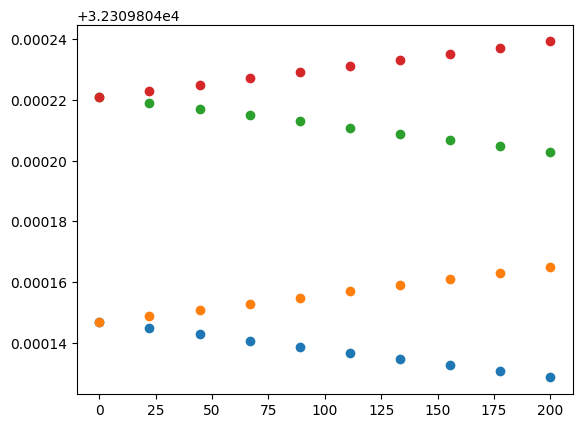

In [40]:
F = 60
m_F = F

# matrix elements of dipole moment operator in hyperfine basis
dip_me, dip_qua, dip_qua_block = dipole_xy2(
    {F: hyper_qua_block_cluster[F]},
    {F: hyper_vec_cluster[F]},
    qua_cluster,
    dipole_cluster,
    m_val=m_F,
)

# field-free Hamiltonian (hyperfine energies)
h0 = np.diag(
    np.concatenate(
        [enr_sym for sym, enr_sym in hyper_enr_cluster[F].items()],
        axis=0,
    )
)

# compute Stark effect for field along Z
field = np.linspace(0, 200, 10) # in V/m
enr = []
vec = []
for fz in field:
    h = h0 - dip_me[-1] * fz * DEBYE_X_VM_TO_INVCM
    e, v = np.linalg.eigh(h)
    enr.append(e)
    vec.append(v)
enr = np.array(enr)
vec = np.array(vec)

for e in enr.T:
    plt.scatter(field, e)

Store solutions for $F_Z=0$ and 200 V/cm in file

In [14]:
with h5py.File(f"h2s_hyperfine_clusters_f{F}.h5", "w") as h5:
    h5.create_dataset("field", data=field)
    h5.create_dataset("energies", data=enr)
    h5.create_dataset("coefficients", data=vec)
    qua_str = [",".join(elem) for elem in dip_qua]
    max_len = max([len(elem) for elem in qua_str])
    qua_ascii = [elem.encode("ascii", "ignore") for elem in qua_str]
    h5.create_dataset(sym, (len(qua_ascii), 1), f"S{max_len}", data=qua_ascii)

In [41]:
print(enr)

[[32309.80414675 32309.80414676 32309.80422107 32309.80422108]
 [32309.80414473 32309.80414878 32309.80421905 32309.8042231 ]
 [32309.8041427  32309.80415081 32309.80421702 32309.80422513]
 [32309.80414067 32309.80415284 32309.80421499 32309.80422716]
 [32309.80413864 32309.80415487 32309.80421296 32309.80422919]
 [32309.80413662 32309.8041569  32309.80421093 32309.80423121]
 [32309.80413459 32309.80415892 32309.80420891 32309.80423324]
 [32309.80413256 32309.80416095 32309.80420688 32309.80423527]
 [32309.80413053 32309.80416298 32309.80420485 32309.8042373 ]
 [32309.8041285  32309.80416501 32309.80420282 32309.80423933]]


## Nuclear-spin density

In [29]:
def psi_on_grid(
    J: int,
    sym: str,
    state_ind: int,
    alpha,
    beta,
    gamma,
    pmax: int = 20,
):
    """Computes rovibrational function for selected state on grid of Euler angles"""

    rot_k, rot_m, rot_mu, k_list, jktau_list = symtop_on_grid_split_angles(
        J, alpha, beta, gamma
    )

    h5 = h5py.File(f"h2s_coefficients_pmax{pmax}_j{J}.h5", "r")
    enr = h5["energies"][sym][state_ind]
    coefs = h5["coefficients"][sym][:, state_ind]
    qua = np.array(
        [elem[0].decode("utf-8").split(",") for elem in h5["quanta"][sym][:]]
    )
    vib_qua = qua[:, 2:6]
    rot_qua = qua[:, 6:9]

    # compute rotational part for all basis functions
    ktau_ind = [
        np.where(
            (jktau_list[:, 0] == str(J))
            & (jktau_list[:, 1] == k)
            & (jktau_list[:, 2] == tau)
        )[0][0]
        for (k, tau) in rot_qua[:, :2]
    ]
    rot_k = rot_k[ktau_ind]  # shape = (ktau, mu, point)

    # unique set of vibrational quanta
    vib_qua_unique = list(set([tuple(elem) for elem in vib_qua]))
    v_ind = [
        np.where(
            (vib_qua[:, 0] == v1)
            & (vib_qua[:, 1] == v2)
            & (vib_qua[:, 2] == v3)
            & (vib_qua[:, 3] == vsym)
        )[0]
        for (v1, v2, v3, vsym) in vib_qua_unique
    ]
    unique_vec = np.zeros((len(qua), len(vib_qua_unique)))
    for i, v in enumerate(v_ind):
        unique_vec[v, i] = 1

    rot_kv = np.einsum("i,img,iv->mvg", coefs, rot_k, unique_vec, optimize="optimal")

    return rot_kv, rot_m, rot_mu, enr, vib_qua_unique

In [30]:
def monte_carlo_distr(npoints, alpha, beta, gamma, dens, xyz):
    fdens = RegularGridInterpolator((alpha, beta, gamma), dens)
    points = np.random.uniform(
        low=[0, 0, 0], high=[2 * np.pi, np.pi, 2 * np.pi], size=(npoints, 3)
    )
    w = fdens(points)
    signs = np.sign(w)
    abs_w = np.abs(w) / np.max(np.abs(dens))
    eta = np.random.uniform(0.0, 1.0, size=len(w))
    ind = np.where(abs_w > eta)
    points = points[ind]
    signs = signs[ind]
    rotmat = Rotation.from_euler("ZYZ", points).as_matrix()
    xyz_sample = np.dot(rotmat, xyz)
    kernel = stats.gaussian_kde(xyz_sample.T)
    weights = kernel(xyz_sample.T)
    return xyz_sample, weights, signs

In [31]:
npoints = 30
alpha = np.linspace(0, 2 * np.pi, npoints)
beta = np.linspace(0, np.pi, npoints)
gamma = np.linspace(0, 2 * np.pi, npoints)
euler_grid = np.array([elem for elem in itertools.product(alpha, beta, gamma)])

In [32]:
atom_xyz = np.array(
    [
        [8.82173006e-01, 0.00000000e00, 9.71108730e-01],
        [8.82173006e-01, 0.00000000e00, -9.71108730e-01],
    ]
)
atom_xyz = atom_xyz / np.linalg.norm(atom_xyz, axis=-1)[:, None]

In [33]:
rot_kv, rot_m, rot_mu, enr, vib_qua = psi_on_grid(50, "A1", 280, alpha, beta, gamma)

den_kv = np.einsum("ivg,jvg->ijg", np.conj(rot_kv), rot_kv, optimize="optimal")
den_m = np.einsum("mig,mjg->mijg", np.conj(rot_m), rot_m, optimize="optimal")
den_mu = np.einsum("ig,jg->ijg", np.conj(rot_mu), rot_mu, optimize="optimal")
dens = np.einsum(
    "ijg,ija,ijb->abg", den_kv, den_m[-1], den_mu, optimize="optimal"
) * np.sin(beta[None, :, None])
dens = np.abs(dens)

atom 0


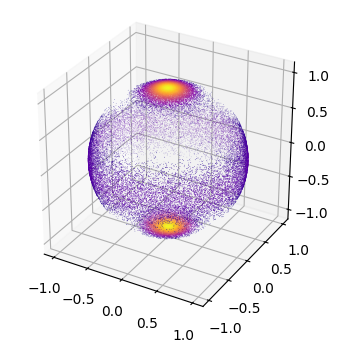

atom 1


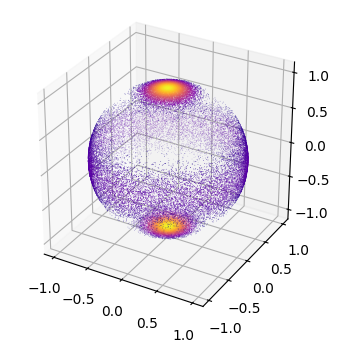

In [34]:
for i, xyz in enumerate(atom_xyz):
    print(f"atom {i}")
    xyz_samples, weights, signs = monte_carlo_distr(
        1000000, alpha, beta, gamma, dens, xyz
    )

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(projection="3d")
    ax.set_box_aspect(aspect=(1, 1, 1))
    ax.axes.set_xlim3d(left=-1.1, right=1.1)
    ax.axes.set_ylim3d(bottom=-1.1, top=1.1)
    ax.axes.set_zlim3d(bottom=-1.1, top=1.1)

    ax.scatter(
        *xyz_samples.T, c=weights, s=1, edgecolor="none", marker=".", cmap="plasma"
    )
    plt.show()

compute densities for F = 60, sym = B1
0 ['60' 'B1' '1' 'A1' '542' 'B1' '60' '0' '2' '1' 'B2' '5' '1' 'A2']
1 ['60' 'A2' '0' 'B2' '544' 'A2' '60' '0' '2' '1' 'B2' '10' '1' 'B1']
0 0 (2, 2, 30, 30, 30, 3, 2)
0 1 (2, 2, 30, 30, 30, 3, 2)
1 0 (2, 2, 30, 30, 30, 3, 2)
1 1 (2, 2, 30, 30, 30, 3, 2)
state index: 0


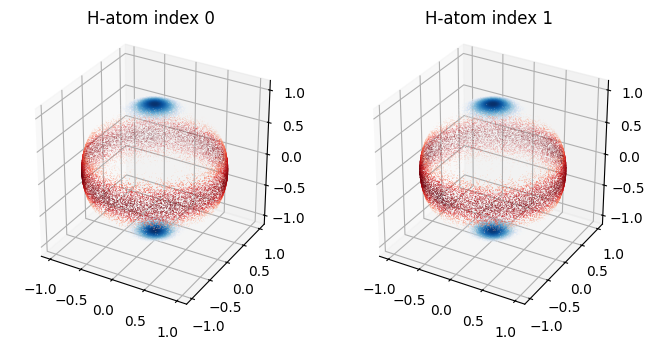

state index: 1


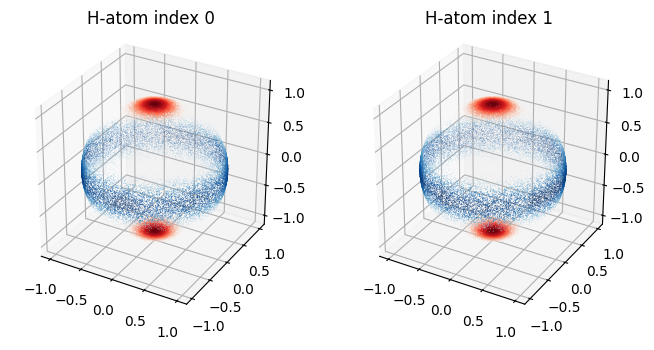

compute densities for F = 60, sym = B2
0 ['60' 'A1' '0' 'B2' '600' 'A1' '60' '1' '1' '1' 'A1' '34' '0' 'A1']
1 ['60' 'B2' '1' 'A1' '599' 'B2' '60' '1' '1' '1' 'A1' '47' '0' 'B2']
0 0 (2, 2, 30, 30, 30, 3, 2)
0 1 (2, 2, 30, 30, 30, 3, 2)
1 0 (2, 2, 30, 30, 30, 3, 2)
1 1 (2, 2, 30, 30, 30, 3, 2)
state index: 0


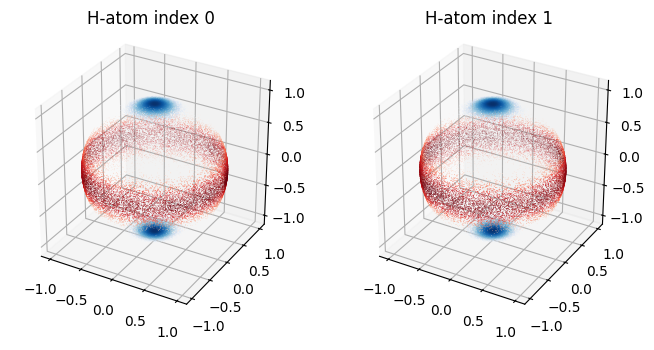

state index: 1


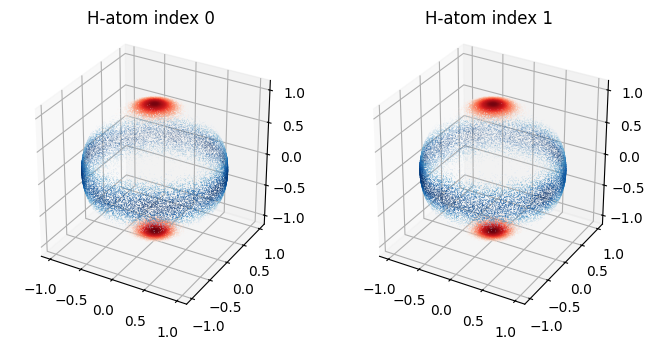

In [35]:
for F in hyper_qua_cluster.keys():

    if F != 60:
        continue

    mF = F

    for sym in hyper_qua_cluster[F].keys():

        print(f"compute densities for F = {F}, sym = {sym}")

        psi_threej = []

        p = F + mF
        ip = int(p)
        assert abs(p - ip) < 1e-16, f"F + mF: {F} + {mF} = {p} is not an integer number"
        prefac = (-1) ** p * np.sqrt(2 * F + 1)

        for i, qua in enumerate(hyper_qua_cluster[F][sym]):
            rov_state_ind = int(qua[4])
            rov_sym = qua[1]
            J = int(qua[0])
            I = int(qua[2])
            print(i, qua)

            two_mI, two_mJ = np.array(
                [
                    (int(mI * 2), int(mJ * 2))
                    for mI in np.linspace(-I, I, int(2 * I) + 1)
                    for mJ in range(-J, J + 1)
                ]
            ).T
            nelem = len(two_mI)
            threej = wigner3j(
                [F * 2] * nelem,
                [I * 2] * nelem,
                [J * 2] * nelem,
                [-mF * 2] * nelem,
                two_mI,
                two_mJ,
                ignore_invalid=True,
            ).reshape(2 * I + 1, 2 * J + 1)

            rot_kv, rot_m, rot_mu, enr, vib_qua = psi_on_grid(
                J, rov_sym, rov_state_ind, alpha, beta, gamma
            )
            rot_m = np.einsum("nm,mig->nig", threej, rot_m, optimize="optimal") * prefac
            psi_threej.append((rot_kv, rot_m, rot_mu, vib_qua, I))

        n = len(psi_threej)
        dens = np.zeros((n, n, npoints, npoints, npoints, 3, 2), dtype=np.complex128)
        for i1, (rot_kv1, rot_m1, rot_mu1, vib_qua1, I1) in enumerate(psi_threej):
            for i2, (rot_kv2, rot_m2, rot_mu2, vib_qua2, I2) in enumerate(psi_threej):
                vib_qua12 = list(set(vib_qua1) & set(vib_qua2))
                vib_ind1 = [vib_qua1.index(v) for v in vib_qua12]
                vib_ind2 = [vib_qua2.index(v) for v in vib_qua12]
                diff = list(set(vib_qua1) - set(vib_qua2))
                assert len(diff) == 0, (
                    f"different lists of vib quanta for basis states (i1, i2) = {(i1, i2)},"
                    + f"diff: {diff}"
                )

                spin_me = spin_me_xy2(I1, I2, 0.5, 0.5)

                den_kv = np.einsum(
                    "ivg,jvg->ijg",
                    np.conj(rot_kv1[:, vib_ind1]),
                    rot_kv2[:, vib_ind2],
                    optimize="optimal",
                )
                den_m = np.einsum(
                    "mig,mn...,njg->ijg...",
                    np.conj(rot_m1),
                    spin_me,
                    rot_m2,
                    optimize="optimal",
                )
                den_mu = np.einsum(
                    "ig,jg->ijg", np.conj(rot_mu1), rot_mu2, optimize="optimal"
                )
                dens[i1, i2] = np.einsum(
                    "ijg,ija...,ijb,b->abg...",
                    den_kv,
                    den_m,
                    den_mu,
                    np.sin(beta),
                    optimize="optimal",
                )
                print(i1, i2, dens.shape)

        dens = np.real(
            np.einsum(
                "ik,ij...,jk->k...",
                np.conj(hyper_vec_cluster[F][sym]),
                dens,
                hyper_vec_cluster[F][sym],
                optimize="optimal",
            )
        )

        for istate in range(2):
            print("state index:", istate)

            fig = plt.figure(figsize=(8, 8))
            axs = [
                fig.add_subplot(1, 2, 1, projection="3d"),
                fig.add_subplot(1, 2, 2, projection="3d"),
            ]
            for ax in axs:
                ax.set_box_aspect(aspect=(1, 1, 1))
                ax.axes.set_xlim3d(left=-1.1, right=1.1)
                ax.axes.set_ylim3d(bottom=-1.1, top=1.1)
                ax.axes.set_zlim3d(bottom=-1.1, top=1.1)

            for i, (xyz, ax) in enumerate(zip(atom_xyz, axs)):
                d = dens[istate, :, :, :, -1, i]
                xyz_samples, weights, signs = monte_carlo_distr(
                    1000000, alpha, beta, gamma, d, xyz
                )

                pos_ind = np.where(signs > 0)
                neg_ind = np.where(signs < 0)
                ax.set_title(f"H-atom index {i}")
                ax.scatter(
                    *xyz_samples[pos_ind].T,
                    c=weights[pos_ind],
                    s=1,
                    edgecolor="none",
                    marker=".",
                    cmap="Reds",
                )
                ax.scatter(
                    *xyz_samples[neg_ind].T,
                    c=weights[neg_ind],
                    s=1,
                    edgecolor="none",
                    marker=".",
                    cmap="Blues",
                )

            plt.show()